# <a name="top"> <p>CIFAR 100 Final Optimization <br /></a>
<strong>CIFAR-100 Practice</strong><br/>
<strong>Redes Neuronales y Aprendizaje Profundo</strong><br/>
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

## Estructura


[Introducción](#introduccion) 

[1. Importación de librerias](#importacion) 
    
[2. Definición de sets y labels](#definicion)

[3. Red neuronal utilizada, definición de capas y activadores ](#redes)

- 3.1. Capas de entrada y de salida
- 3.2. Capas intermedias
- 3.3. Activador utilizado en capas intermedias
- 3.4. Activador de la red
- 3.5. Función de perdida
- 3.6. Optimizadores de redes utilizados

[4. Pruebas de diferentes modelos](#pruebas)

- 4.1. Prueba de modelo con Dropout (batch size=50, epoch 40, RMSprop)
- 4.2. Pruebas con data augmentation

[5. Mejor modelo obtenido](#mejor)

[6. Conclusiones Generales](#conclusiones) 
    

<hr style="border:1px solid gray">

##  <a name="introduccion"> Introducción  </a>

En esta 3ª práctica deberemos obtener el mayor score con el dataset CIFAR-100. Para ello deberemos utilizar los diferentes tipos de redes/capas y optimizadores vistos en clase, modificando sus hiperparámetros, batch sizes, etc... **En este documento únicamente se encuentran un par de test con los 'mejores' resultados.**

**Las diferentes pruebas realizadas se pueden encontrar en el archivo `raw_tests`**, el cual es un **borrador en sucio donde se estuvieron probando diferentes tests y obsevando los errores, por lo que carece de estructura.** Los  mensajes de error deben a cancelar el proceso al ver que los resultados no eran adecuados.

Fuera del documento, se realizaron más pruebas aparte sin mucha relevancia.

##  <a name="importacion"> 1. Importación de librerias  </a>

In [2]:
# Load the tensorflow and basic libraries.

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization,  UpSampling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.keras.layers import Dropout
from keras import datasets, Sequential
from tensorflow.keras import optimizers
from tensorflow.data import Dataset

##  <a name="definicion">  2. Definición de sets y labels </a>


**CIFAR-100 es un conjunto de datos de imágenes para el aprendizaje automático creado por la Universidad de Toronto. Consiste en 100 clases diferentes de imágenes, con 600 imágenes por clase. Las imágenes están divididas en un conjunto de entrenamiento y un conjunto de prueba, y cada una está etiquetada con una de las 100 clases.**


Definimos el set de training y el set de validación para trabajar con ellos.



In [4]:
# Load CIFAR-100 dataset and split into train and test.

(X_train, y_train), (X_validation, y_validation) = cifar100.load_data() 

# Normalization of the values.

X_train = X_train/255 
X_validation = X_validation/255

Definimos las diferentes clases de imagenes y comprobamos que se hayan cargado correctamente

Número de elementos en el dataset =  60000


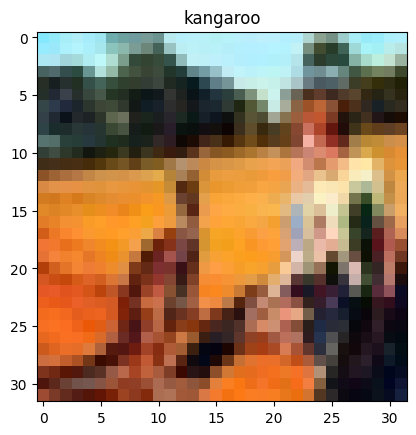

In [5]:
# Definition of the labels.

labels = ["apple","aquarium_fish","baby","bear","beaver","bed","bee","beetle","bicycle","bottle","bowl","boy","bridge","bus",
          "butterfly","camel","can","castle","caterpillar","cattle","chair","chimpanzee","clock","cloud","cockroach","couch",
          "crab","crocodile","cup","dinosaur","dolphin","elephant","flatfish","forest","fox","girl","hamster","house","kangaroo",
          "keyboard","lamp","lawn_mower","leopard","lion","lizard","lobster","man","maple_tree","motorcycle","mountain","mouse",
          "mushroom","oak_tree","orange","orchid","otter","palm_tree","pear","pickup_truck","pine_tree","plain","plate","poppy",
          "porcupine","possum","rabbit","raccoon","ray","road","rocket","rose","sea","seal","shark","shrew","skunk","skyscraper",
          "snail","snake","spider","squirrel","streetcar","sunflower","sweet_pepper","table","tank","telephone","television",
          "tiger","tractor","train","trout","tulip","turtle","wardrobe","whale","willow_tree","wolf","woman","worm"]


# Print number of elements in the dataset.

print('Número de elementos en el dataset = ',X_train.shape[0]+X_validation.shape[0])

# Plot a random picture with his label.

plt.title(labels[int(y_train[83])])
plt.imshow(X_train[83])
plt.show()


##  <a name="redes">  3. Red neuronal utilizada, definición de capas y activadores </a>


En general, para problemas de clasificación de imágenes, una red neuronal convolucional (CNN) suele ser la más utilizada, dado que son muy eficientes para extraer características de imágenes. Es por ello que para esta práctica utilizaremos redes neuronales convolucionales.

### 3.1. Capas de entrada y de salida


En primer lugar configuraremos las capas de entrada y de salida, basandonos en el problema que queremos resolver, de clasificación.

 - Para la **capa de entrada designamos un input de 32,32,3**. Dado que nuestras imagenes tienen un tamaño de 32x32 pixeles y 3 canales de color: rojo, verde y azul (RGB).
 
 
 - Para la **capa de salida designamos un output de 100,** dado que dispondemos de 100 tipos de clases que queremos clasificar, aplicando un activador softmax, que es el más recomendable para problemas de clasificación multiclase, designando un % de probabilidad de pertenecer a cada clase. 

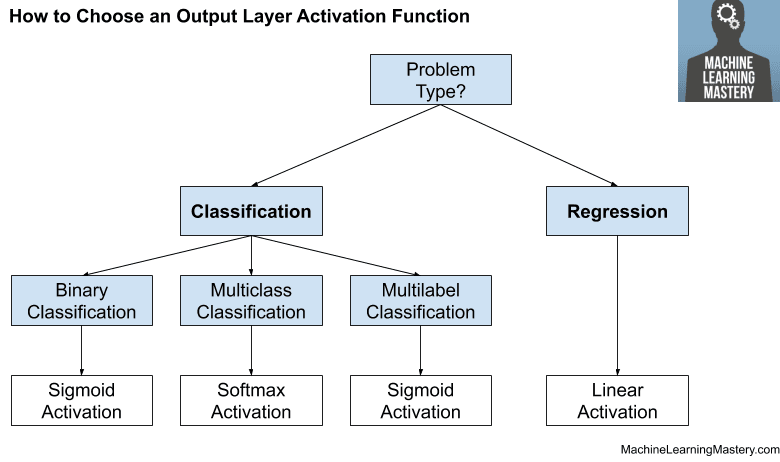

In [ ]:
# Create the input layer.

input = Input(shape=(32,32,3))

# Create the output layer.

output = Dense(units=100, activation='softmax')

### 3.2. Capas intermedias

En cuanto a las capas que utilizaremos en nuestra red neuronal convolucional, trateremos de aplicar diferentes tipos en función de su arquitectura, pero principalmente usaremos las siguientes:

- **Capas de convolución**: realizan el procesamiento de los datos de entrada y extraen características útiles para la tarea en cuestión. Estas capas **suelen constar de filtros que se deslizan sobre las imágenes de entrada y extraen patrones locales en las imágenes**.


- **Capas de pooling**: se utilizan para **reducir la dimensionalidad de los datos** y para hacer que el modelo sea más invariante a pequeñas transformaciones en las imágenes de entrada. Las capas de pooling suelen utilizar operaciones como la media o el máximo para agregar los valores de los píxeles en una región de la imagen.


- **Capas densas (fully-connected)**: están formadas por una **gran cantidad de neuronas y que se utilizan para clasificar las imágenes en diferentes clases**. Estas capas suelen tener una gran cantidad de parámetros entrenables y se utilizan para aprender relaciones complejas entre los datos de entrada y las clases de salida.

Además realizaremos laguna prueba con modelos secuenciales.

### 3.3. Activador utilizado en capas intermedias

Nuestras capas deberán de contener un activador, para este problema **utilizaremos el activador ReLU**, el cual es ideal para clasificación, dado que **previene el sobreajuste del modelo, mejora su rendimiento en el conjunto de datos de prueba, permite a las redes modelar relaciones no lineales en los datos de entrada (las imágenes contienen patrones complejos) y es muy eficiente computacionalmente.**

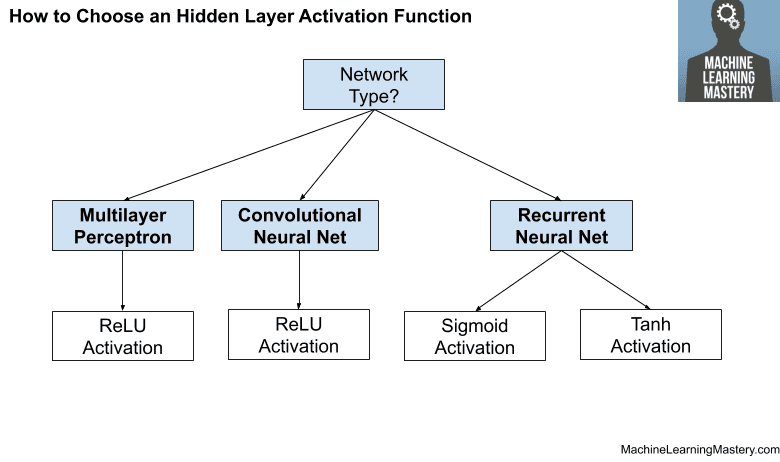

### 3.4. Activador de la red

El activador utilizado para la red neuronal será el **algoritmo Adam**. _Adam es un optimizador que combina el SGD y RMSProp y utiliza una tasa de aprendizaje adaptativa para cada parámetro del modelo_. 

Se ha seleccionado, dado que **obtiene buenos resultados para problemas de clasificación y es sencillo de utilizar e implementar**.

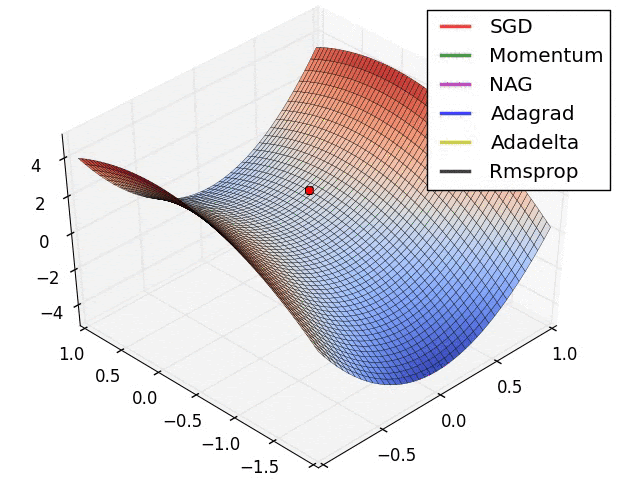

### 3.5. Función de perdida

Para nuestro modelo, escogeremos la función de perdida **SparseCategoricalCrossentropy** . La entropía cruzada categórica es una función de pérdida que **se utiliza para medir el error entre las predicciones del modelo y las etiquetas verdaderas en un problema de clasificación**. Lo cual **nos interesa al ser un problema de clasificación multiclase.**

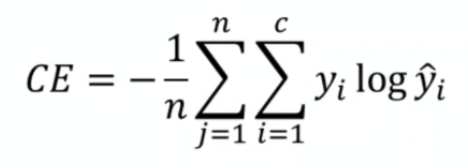

### 3.6. Optimizadores de redes utilizados

- **Dropout**: técnica utilizada en entrenamiento de redes neuronales para reducir el sobreajuste (overfitting). Consiste en ignorar aleatoriamente un porcentaje de las neuronas en cada capa de la red durante el entrenamiento, lo que obliga a la red a aprender características más generales que no dependan solo de un subconjunto específico de neuronas.


- **Data augmentation**: consiste en generar nuevos ejemplos de entrenamiento a partir de los datos originales, utilizando técnicas como el cambio de escala, rotación y deformación de las imágenes. Esto puede ayudar a mejorar el rendimiento de un modelo de aprendizaje automático, ya que proporciona más información y variedad a la hora de entrenar el modelo.


- **Early stopping** : técnica utilizada para evitar el sobreentrenamiento en un modelo de aprendizaje automático. Consiste en detener el entrenamiento del modelo antes de que se alcance el máximo número de iteraciones definido, si se observa que el desempeño del modelo en un conjunto de datos de validación comienza a empeorar. 

##  <a name="pruebas"> 4. Pruebas de diferentes modelos</a>


### 4.1. Prueba de modelo con Dropout (batch size=50, epoch 40, RMSprop) 

In [7]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=200, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=600, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = optimizers.RMSprop(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(X_train,y=y_train, batch_size=50, epochs=40, validation_data=(X_validation, y_validation),validation_steps=200)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 25)        700       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 25)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 25)       100       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 100)       22600     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 100)        0   

### 4.2. Pruebas con data augmentation

Modificamos el  dataset utilizando data augmentation.

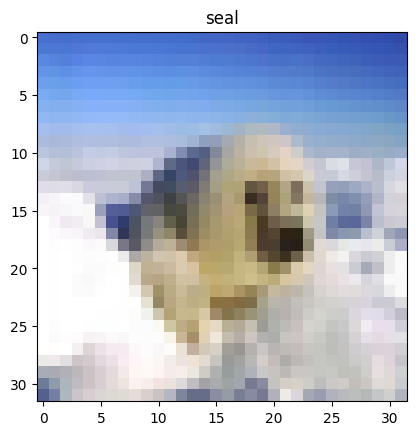

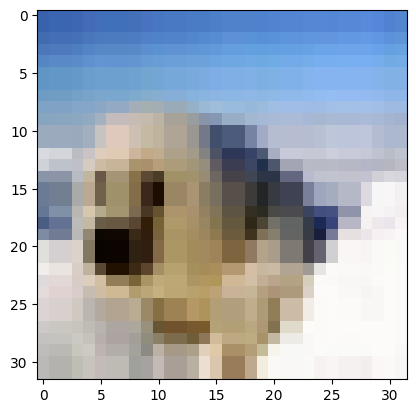

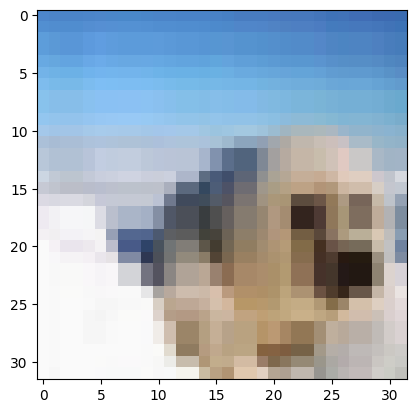

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


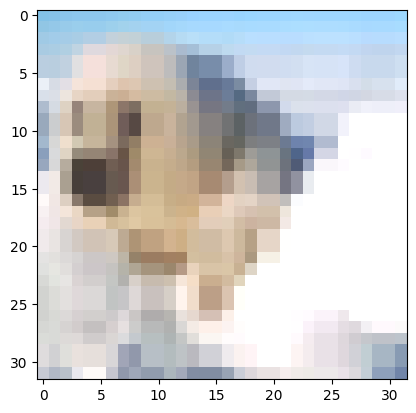

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


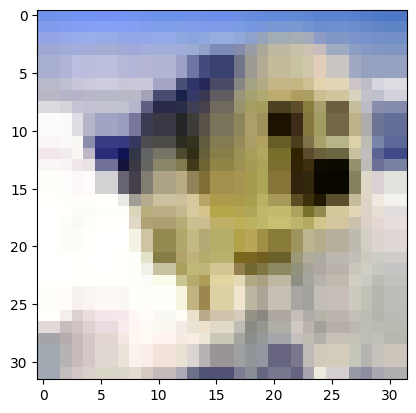

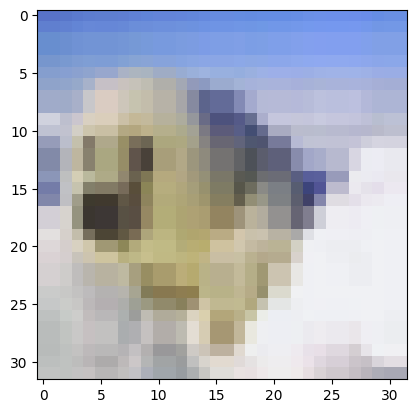

In [6]:
# Creamos un Dataset utilizando numpys. Definimos dataset.
train_ds = Dataset.from_tensor_slices((X_train, y_train))
val_ds = Dataset.from_tensor_slices((X_validation, y_validation))

# Seleccionamos el batch_size que
batch_size = 50

# Creamos una función que perturbará de forma aleatoria las imágenes. Modifica la imagen entre medias, contraste, luminosidad....
# Las etiquetas quedan invariantes
def processing_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.resize(image, (40,40), method='nearest',antialias=False)
    image = tf.image.random_crop(image, (32,32,3))
    return image, label


# Esta función hará las modificaciones pertinentes al dataset para poder usarlo durante el entrenamiento. ç


def data_aug(ds: Dataset, shuffle=False, augment=False):
    # Hacemos que el dataset se repita de manera indefinida. Se come el dataset de tensor flow, concatenamos el dataset una vez detras de otro
    ds = ds.repeat()

    # Aleatorizamos el dataset usando un buffer de 5000. Baraja los elementos, poner un número grande
    if shuffle:
        ds = ds.shuffle(5000)

    # Aplicamos las transformaciones pertinentes. Definidas anteriormente, utilizando 4 operaciones en paralelo.
    if augment:
        ds = ds.map(processing_data,num_parallel_calls=4)

    # Hacemos que el dataset este formado por batches
    ds = ds.batch(batch_size)

    # Devolvemos el dataset precargándolo
    return ds.prefetch(buffer_size=4)

# Aplicamos la función data_aug a nuestro dataset
train_ds = data_aug(train_ds, shuffle=True, augment=True)
# Al dataset de validación no le aplicamos perturbaciones
val_ds = data_aug(val_ds)


# Visualizemos unos ejemplos de como la función processing_data modifica las imágenes
plt.title(labels[int(y_train[62])])
plt.imshow(X_train[62])
plt.show()
for _ in range(5):
    image_mod = np.array(processing_data(X_train[62], 0)[0])
    plt.imshow(image_mod)
    plt.show()


#### 4.2.1.  Modelo secuencial (batch size= 20, epochs = 100, RMSprop) 

In [9]:
model = Sequential()
model.add(Conv2D(50, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(100, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(200, (2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(300, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(400, (4, 4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


# optimizador
optimizer = optimizers.RMSprop(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True) 

history = model.fit(train_ds, batch_size=20, epochs=100,  steps_per_epoch=1000, validation_data=val_ds,validation_steps=200)

Epoch 1/100
1000/1000 [==============================] - 27s 22ms/step - loss: 4.1943 - accuracy: 0.0758 - val_loss: 3.6200 - val_accuracy: 0.1405
Epoch 2/100
1000/1000 [==============================] - 22s 22ms/step - loss: 3.5066 - accuracy: 0.1623 - val_loss: 3.1515 - val_accuracy: 0.2157
Epoch 3/100
1000/1000 [==============================] - 22s 22ms/step - loss: 3.1946 - accuracy: 0.2200 - val_loss: 2.9549 - val_accuracy: 0.2715
Epoch 4/100
1000/1000 [==============================] - 23s 23ms/step - loss: 2.9955 - accuracy: 0.2587 - val_loss: 2.7305 - val_accuracy: 0.3072
Epoch 5/100
1000/1000 [==============================] - 23s 23ms/step - loss: 2.8626 - accuracy: 0.2840 - val_loss: 2.6592 - val_accuracy: 0.3252
Epoch 6/100
1000/1000 [==============================] - 22s 22ms/step - loss: 2.7575 - accuracy: 0.3106 - val_loss: 2.5294 - val_accuracy: 0.3574
Epoch 7/100
1000/1000 [==============================] - 22s 22ms/step - loss: 2.6538 - accuracy: 0.3258 - val_loss: 2

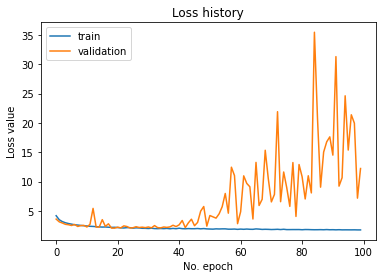

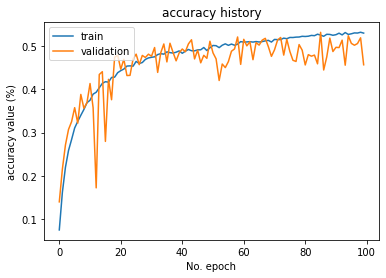

In [11]:
show_history(history)

#### 4.2.2.  Modelo secuencial (batch size= 20, epochs = 100, Adam) 

In [12]:
model = Sequential()
model.add(Conv2D(50, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(100, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(200, (2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(300, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(400, (4, 4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True) 

history = model.fit(train_ds, batch_size=20, epochs=100,  steps_per_epoch=1000, validation_data=val_ds,validation_steps=200)

Epoch 1/100
1000/1000 [==============================] - 22s 21ms/step - loss: 4.1501 - accuracy: 0.0810 - val_loss: 3.4896 - val_accuracy: 0.1618
Epoch 2/100
1000/1000 [==============================] - 21s 21ms/step - loss: 3.4176 - accuracy: 0.1751 - val_loss: 3.0255 - val_accuracy: 0.2540
Epoch 3/100
1000/1000 [==============================] - 21s 21ms/step - loss: 3.0343 - accuracy: 0.2456 - val_loss: 2.8192 - val_accuracy: 0.2915
Epoch 4/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2.8134 - accuracy: 0.2896 - val_loss: 2.7946 - val_accuracy: 0.3023
Epoch 5/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2.6557 - accuracy: 0.3181 - val_loss: 2.7398 - val_accuracy: 0.3221
Epoch 6/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2.5317 - accuracy: 0.3422 - val_loss: 2.4124 - val_accuracy: 0.3757
Epoch 7/100
1000/1000 [==============================] - 21s 21ms/step - loss: 2.4258 - accuracy: 0.3654 - val_loss: 2

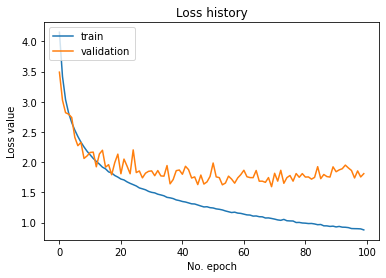

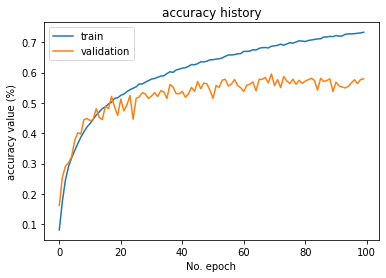

In [13]:
show_history(history)

#### 3.2.3.  Modelo secuencial (batch size= 20, epochs = 150, Adam)

In [14]:
cnn_clf = Sequential()
cnn_clf.add(Conv2D(50, (3, 3), padding='same', input_shape=(32,32,3)))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(Conv2D(32, (3, 3), padding='same'))
cnn_clf.add(Activation('relu'))
cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf.add(Conv2D(100, (3, 3), padding='same'))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(Conv2D(32, (3, 3), padding='same'))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))
cnn_clf.add(Dropout(0.5))

cnn_clf.add(Conv2D(200, (2, 2), padding='same'))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(Conv2D(300, (5, 5), padding='same'))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))


cnn_clf.add(Conv2D(400, (4, 4), padding='same'))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))

cnn_clf.add(Flatten())
cnn_clf.add(Dense(500, kernel_initializer='glorot_uniform'))
cnn_clf.add(BatchNormalization())
cnn_clf.add(Activation('relu'))
cnn_clf.add(Dropout(0.5))
cnn_clf.add(Dense(100, activation='softmax'))


# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
cnn_clf.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True) 

history = cnn_clf.fit(train_ds, batch_size=3, epochs=150,  steps_per_epoch=1000, validation_data=val_ds,validation_steps=200)

Epoch 1/150
1000/1000 [==============================] - 23s 22ms/step - loss: 4.1454 - accuracy: 0.0821 - val_loss: 4.2449 - val_accuracy: 0.0862
Epoch 2/150
1000/1000 [==============================] - 21s 21ms/step - loss: 3.4216 - accuracy: 0.1746 - val_loss: 3.0265 - val_accuracy: 0.2408
Epoch 3/150
1000/1000 [==============================] - 21s 21ms/step - loss: 3.0149 - accuracy: 0.2502 - val_loss: 2.8093 - val_accuracy: 0.2893
Epoch 4/150
1000/1000 [==============================] - 21s 21ms/step - loss: 2.7808 - accuracy: 0.2933 - val_loss: 2.7419 - val_accuracy: 0.3060
Epoch 5/150
1000/1000 [==============================] - 21s 21ms/step - loss: 2.6128 - accuracy: 0.3286 - val_loss: 2.4002 - val_accuracy: 0.3748
Epoch 6/150
1000/1000 [==============================] - 21s 21ms/step - loss: 2.5009 - accuracy: 0.3518 - val_loss: 2.6819 - val_accuracy: 0.3437
Epoch 7/150
1000/1000 [==============================] - 26s 26ms/step - loss: 2.3908 - accuracy: 0.3756 - val_loss: 2

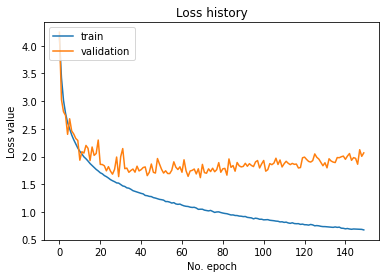

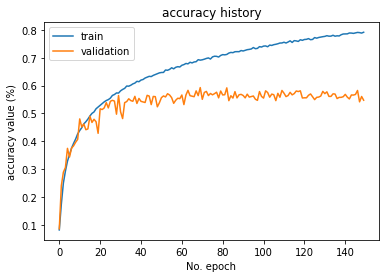

In [15]:
show_history(history)

##  <a name="mejor"> 5. Mejor modelo obtenido</a>


Tras realizar numerosas pruebas, el mejor modelo que hemos obtenido ha sido el del punto 3.2.2. Con un accuracy del 58%.

In [ ]:
model = Sequential()
model.add(Conv2D(50, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(100, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(200, (2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(300, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(400, (4, 4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True) 

history = model.fit(train_ds, batch_size=20, epochs=100,  steps_per_epoch=1000, validation_data=val_ds,validation_steps=200)

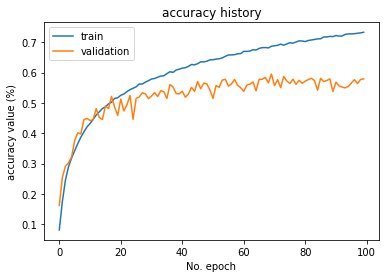

##  <a name="conclusiones"> 6. Conclusiones Generales</a>


- **Tras realizar numerosas pruebas aplicando diferentes métodos de optimización, el mejor modelo sin cometer overfitting ha obtenido un accuracy del 58%. Fuera de los documentos hemos llegado a obtener resultados ligeramente superiores, pero llegando a alcanzar el set de tet un accuracy de prácticamente el 97%, por lo que llegó a ser descartado.**


- **El accuracy comparandolo con el CIFAR 10 es mucho menor, principalmente debido a que contiene un número mayor de clases que clasificar, siendo más específico. Además de que CIFAR 100 contiene 10 veces más imágenes, aumentando la complejidad.**


- **El score obtenido es posible que se pueda mejorar, sin embargo, requiriendo una mayor capacidad de cómputo y desarrollo de las redes.**

[Ir arriba del documento](#top)